In [1]:
# imports required
import numpy
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt

### 1. Load Test and Train Files

In [2]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = "train_data/train"
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_train += len(files)
    
folder = "train_data/test"
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_validation += len(files)
    
print(files_train, files_validation)

381 164


### 2. Set key parameters

In [3]:
# set up the values of parameteres
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [4]:
model = applications.VGG16(weights = "imagenet", include_top = False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

In [5]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(model.input, predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

In [6]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

# generates batches for train and val using directory path
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [7]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor = 'val_acc', verbose = 1, save_best_only = True,
                             save_weights_only = False, mode = 'auto', period = 1)

early = EarlyStopping(monitor = 'val_acc', min_delta = 0, patience = 10, verbose = 1, mode = 'auto')

In [8]:
### Start training!

history_object = model_final.fit_generator(train_generator,
#                                             samples_per_epoch = nb_train_samples,
                                            epochs = epochs,
                                            validation_data = validation_generator,
#                                             nb_val_samples = nb_validation_samples,
                                            callbacks = [checkpoint, early])

Epoch 1/15


/home/nikhil/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12/12 [==============================] - 8s 606ms/step - loss: 0.5095 - accuracy: 0.7640 - val_loss: 0.4258 - val_accuracy: 0.8110
Epoch 2/15
12/12 [==============================] - 7s 582ms/step - loss: 0.3763 - accuracy: 0.8413 - val_loss: 0.2855 - val_accuracy: 0.8841
Epoch 3/15
12/12 [==============================] - 7s 590ms/step - loss: 0.2186 - accuracy: 0.9626 - val_loss: 0.2473 - val_accuracy: 0.9207
Epoch 4/15
12/12 [==============================] - 7s 599ms/step - loss: 0.1547 - accuracy: 0.9665 - val_loss: 0.2141 - val_accuracy: 0.9085
Epoch 5/15
12/12 [==============================] - 7s 606ms/step - loss: 0.1175 - accuracy: 0.9729 - val_loss: 0.1775 - val_accuracy: 0.9146
Epoch 6/15
12/12 [==============================] - 7s 611ms/step - loss: 0.1065 - accuracy: 0.9704 - val_loss: 0.1834 - val_accuracy: 0.9268
Epoch 7/15
12/12 [==============================] - 8s 639ms/step - loss: 0.0707 - accuracy: 0.9846 - val_loss: 0.1641 - val_accuracy: 0.9390
Epoch 8/15
12/12 

### 4 plot accuracy and loss

In [9]:
print(history_object.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


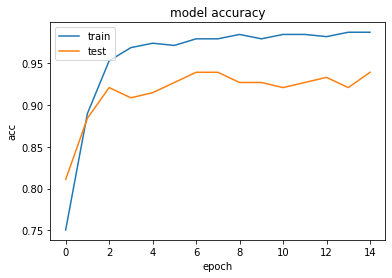

In [10]:
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

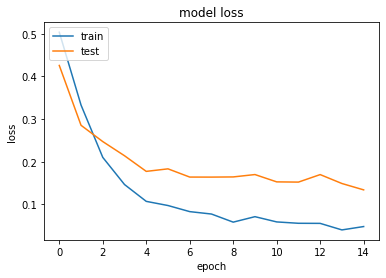

In [11]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()